<a href="https://colab.research.google.com/github/zelal-Eizaldeen/DLH_Project_HurtfulWords_Paper/blob/main/1_Sampling_pc_z.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import random

# Implementation Strategy in Code:
To replicate the paper's methodology in code, you can follow these steps:

# 1. Preprocessing the Data:

Load clinical notes from the MIMIC-III dataset.

Clean the notes and apply special tokens to represent PHI.

Prepare sequences of clinical notes for input into SciBERT.

# 2. Model Initialization:

Initialize SciBERT for tokenization and embedding generation.

Fine-tune SciBERT using the preprocessed clinical notes.

# 3. Two-Stage Training:

In the first stage, train with sequences of 128 tokens.

Afterward, extend the sequences to 512 tokens and continue training.

# Libraries

In [ ]:
PATH_TO_SAMPLED_CSVs="/content/drive/MyDrive/Payel-DLH-related/DataFiles/sampled_files/"

In [ ]:
PATH_TO_ORIG_CSVs="/content/drive/MyDrive/Payel-DLH-related/DataFiles/mimic-iii-clinical-database-1.4"

In [ ]:
!ls $PATH_TO_SAMPLED_CSVs

sampled_ADMISSIONS.csv	   sampled_ICUSTAYS.csv    sampled_PATIENTS.csv
sampled_DIAGNOSES_ICD.csv  sampled_NOTEEVENTS.csv


In [ ]:
!ls $PATH_TO_ORIG_CSVs

ADMISSIONS.csv		   D_CPT.csv		 INPUTEVENTS_CV.csv	 PRESCRIPTIONS.csv
CALLOUT.csv		   DIAGNOSES_ICD.csv	 INPUTEVENTS_MV.csv	 PROCEDUREEVENTS_MV.csv
CAREGIVERS.csv		   D_ICD_DIAGNOSES.csv	 LABEVENTS.csv		 PROCEDURES_ICD.csv
CHARTEVENTS.csv		   D_ICD_PROCEDURES.csv  LICENSE.txt		 README.md
checksum_md5_unzipped.txt  D_ITEMS.csv		 MICROBIOLOGYEVENTS.csv  SERVICES.csv
checksum_md5_zipped.txt    D_LABITEMS.csv	 NOTEEVENTS.csv		 SHA256SUMS.txt
CPTEVENTS.csv		   DRGCODES.csv		 OUTPUTEVENTS.csv	 TRANSFERS.csv
DATETIMEEVENTS.csv	   ICUSTAYS.csv		 PATIENTS.csv


In [ ]:
!pip install transformers
!pip install torch
!pip install sklearn
!pip install scipy

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


# Sampling the most important dataset files

In [ ]:

#This code didn't work with NOTEEVENTS.csv because it is too large.
#The following cell for NOTEEVENTS.csv

# Define the list of CSV file paths
csv_files = [
    "ADMISSIONS.csv",  "DIAGNOSES_ICD.csv","ICUSTAYS.csv", "PATIENTS.csv"
]

# File path for PATIENTS.csv
patients_path = f"{PATH_TO_ORIG_CSVs}/PATIENTS.csv"

# Step 1: Load the specific subject_id's from PATIENTS.csv
# Let's say you want to select a random sample of 5% of subject_id's from NOTEEVENTS.csv
df_patients = pd.read_csv(patients_path)

# Randomly sample 5% of unique subject_ids (you can adjust this as needed)
subject_ids_to_use = df_patients['SUBJECT_ID'].dropna().unique()  # Get unique subject_ids
subject_ids_to_use = random.sample(list(subject_ids_to_use), int(len(subject_ids_to_use) * 0.05))  # Randomly select 5%

# Step 2: Loop over all CSV files and filter rows with matching subject_id
filtered_data = {}  # Store filtered DataFrames for each CSV file

for csv_file in csv_files:
    try:
        # Read the CSV file
        df = pd.read_csv(f"{PATH_TO_ORIG_CSVs}/{csv_file}")

        # Check if 'subject_id' column exists in the current CSV
        if 'SUBJECT_ID' in df.columns:
            # Filter rows with subject_id matching the selected ones
            df_filtered = df[df['SUBJECT_ID'].isin(subject_ids_to_use)]

            # Store the filtered DataFrame in the dictionary
            filtered_data[csv_file] = df_filtered

            # Drop duplicate rows
            filtered_data[csv_file] = filtered_data[csv_file].drop_duplicates()

            # Optionally save the filtered data to new CSV files
            filtered_data[csv_file].to_csv(f"{PATH_TO_SAMPLED_CSVs}/sampled_{csv_file}", index=False)

    except Exception as e:
        print(f"Could not process {csv_file}: {e}")

# You now have filtered data for all CSV files with the common subject_id
print("Filtered data from all CSVs with common subject_id has been saved.")


Filtered data from all CSVs with common subject_id has been saved.


In [ ]:
# Define the list of CSV file paths
# csv_files = [
#     "ADMISSIONS.csv", "CAREGIVERS.csv", "CHARTEVENTS.csv", "CPTEVENTS.csv", "DATETIMEEVENTS.csv",
#     "DIAGNOSES_ICD.csv", "D_CPT.csv", "D_ICD_DIAGNOSES.csv", "D_ICD_PROCEDURES.csv", "D_ITEMS.csv",
#     "D_LABITEMS.csv", "DRGCODES.csv", "ICUSTAYS.csv", "INPUTEVENTS_CV.csv", "INPUTEVENTS_MV.csv",
#     "LABEVENTS.csv", "MICROBIOLOGYEVENTS.csv", "NOTEEVENTS.csv", "OUTPUTEVENTS.csv", "PATIENTS.csv",
#     "PRESCRIPTIONS.csv", "PROCEDUREEVENTS_MV.csv", "PROCEDURES_ICD.csv", "SERVICES.csv", "TRANSFERS.csv"
# ]

In [ ]:
sampled_patients = pd.read_csv(f"{PATH_TO_SAMPLED_CSVs}/sampled_PATIENTS.csv")
sampled_patients.shape

(2326, 8)

In [ ]:
sampled_admisions = pd.read_csv(f"{PATH_TO_SAMPLED_CSVs}/sampled_ADMISSIONS.csv")
sampled_admisions.shape

(2950, 19)

In [ ]:
import pandas as pd

# Define file path
file_path = f"{PATH_TO_SAMPLED_CSVs}/sampled_ADMISSIONS.csv"

# Load the data
df_admissions = pd.read_csv(file_path)

# Count unique SUBJECT_IDs
num_unique_subjects = df_admissions["SUBJECT_ID"].nunique()

print(f"Number of unique subjects in sampled admissions file: {num_unique_subjects}")

Number of unique subjects in sampled admissions file: 2326


In [ ]:
sampled_diag_icd = pd.read_csv(f"{PATH_TO_SAMPLED_CSVs}/sampled_DIAGNOSES_ICD.csv")
sampled_diag_icd.shape

(32090, 5)

In [ ]:
# Define file path
file_path = f"{PATH_TO_SAMPLED_CSVs}/sampled_DIAGNOSES_ICD.csv"

# Load the data
df_admissions = pd.read_csv(file_path)

# Count unique SUBJECT_IDs
num_unique_subjects = df_admissions["SUBJECT_ID"].nunique()

print(f"Number of unique subjects in sampled diagnoses file: {num_unique_subjects}")

Number of unique subjects in sampled diagnoses file: 2326


In [ ]:
sampled_icustays = pd.read_csv(f"{PATH_TO_SAMPLED_CSVs}/sampled_ICUSTAYS.csv")
sampled_icustays.shape


(3092, 12)

In [ ]:
# Define file path
file_path = f"{PATH_TO_SAMPLED_CSVs}/sampled_ICUSTAYS.csv"

# Load the data
df_admissions = pd.read_csv(file_path)

# Count unique SUBJECT_IDs
num_unique_subjects = df_admissions["SUBJECT_ID"].nunique()

print(f"Number of unique subjects in sampled icu stays file: {num_unique_subjects}")

Number of unique subjects in sampled icu stays file: 2325


Sampling NOTEEVENTS again, for subjects within sampled_PATIENTS.csv

# NOTEEVENTS
To implement this pipeline, follow these steps:

1. Preprocess the MIMIC-III NOTEEVENTS.csv dataset
Extract clinical notes

Tokenize and preprocess the text

Train a ClinicalBERT model using SciBERT as the base model

2. Train Classifiers for 57 Finetuning Tasks
Define 57 binary classification tasks

Use pretrained embeddings from ClinicalBERT

Train classifiers (e.g., Logistic Regression, MLP, or Transformer-based models)

3. Evaluate Discrepancy Gaps
Compute fairness metrics (Section 4.2)

Use bootstrapping (1000 samples) on the test set

Establish 95% confidence intervals

Count statistically significant gaps per protected group

In [ ]:
import pandas as pd

# Define file paths
patients_file = f"{PATH_TO_SAMPLED_CSVs}/sampled_PATIENTS.csv"
noteevents_file = f"{PATH_TO_ORIG_CSVs}/NOTEEVENTS.csv"
output_file = f"{PATH_TO_SAMPLED_CSVs}/sampled_NOTEEVENTS.csv"

# Load sampled patients file
df_patients = pd.read_csv(patients_file)

# Extract unique SUBJECT_IDs from sampled patients
subject_ids_to_keep = set(df_patients["SUBJECT_ID"].dropna().unique())

# Define chunk size (adjust based on available memory)
chunk_size = 100000  # Number of rows per chunk

# Open output file and write only the filtered rows
with pd.read_csv(noteevents_file, chunksize=chunk_size) as reader:
    for i, chunk in enumerate(reader):
        # Filter rows where SUBJECT_ID is in the sampled list
        chunk_filtered = chunk[chunk["SUBJECT_ID"].isin(subject_ids_to_keep)]

        # Write the filtered data to a new file (append mode for subsequent chunks)
        chunk_filtered.to_csv(output_file, mode="a", index=False, header=(i == 0))

print("Filtered NOTEEVENTS.csv has been saved as sampled_NOTEEVENTS.csv")

<ipython-input-37-8a34831cd6a3>:19: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Filtered NOTEEVENTS.csv has been saved as sampled_NOTEEVENTS.csv


In [ ]:
sampled_noteevents = pd.read_csv(f"{PATH_TO_SAMPLED_CSVs}/sampled_NOTEEVENTS.csv")
sampled_noteevents.shape

(108216, 11)

In [ ]:
import pandas as pd

# Define file path
file_path = f"{PATH_TO_SAMPLED_CSVs}/sampled_NOTEEVENTS.csv"

# Load the data
df_admissions = pd.read_csv(file_path)

# Count unique SUBJECT_IDs
num_unique_subjects = df_admissions["SUBJECT_ID"].nunique()

print(f"Number of unique subjects in sampled noteevents file: {num_unique_subjects}")

Number of unique subjects in sampled noteevents file: 2303


#Example of using SciBERT

# 1. Import SciBERT from Hugging Face
SciBERT is available via the Hugging Face model hub, which is a BERT-based model pre-trained on scientific literature. You can load it using the transformers library.


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load SciBERT model (trained on scientific text) for embedding
model_name = "allenai/scibert_scivocab_uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

# 2. Gets Word Embeddings:
 We tokenize and convert words into embeddings using SciBERT. The embeddings represent the semantic meaning of the word in a high-dimensional vector space.



In [ ]:
# Function to get embedding for a word
def get_embedding(word):
    inputs = tokenizer(word, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze()  # Average embedding of tokens
    return embedding

# Example: Get embedding for the word 'diabetes'
word = "diabetes"
embedding = get_embedding(word)
print(embedding)


NameError: name 'tokenizer' is not defined

#3. Define Bias-Related Terms
You will want to measure how biased words (e.g., gendered terms or other sensitive terms) are with respect to clinical terms. Below is an example of how to define your sensitive words.


In [ ]:
# Example bias-related words (e.g., gendered words)
gendered_terms = ['he', 'she', 'man', 'woman', 'male', 'female']

# Example clinical terms (e.g., disease names)
clinical_terms = ['diabetes', 'hypertension', 'cancer', 'asthma', 'stroke']

#4. Calculate Cosine Similarity Between Embeddings
You will calculate cosine similarity between the embeddings of clinical terms and the bias-related terms (e.g., gendered terms).

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_bias(embedding1, embedding2):
    similarity = cosine_similarity(embedding1.unsqueeze(0), embedding2.unsqueeze(0))
    return similarity[0][0]

# Function to measure bias for clinical terms with respect to bias terms
def measure_bias_for_terms(target_terms, bias_terms):
    biases = {}
    for target_word in target_terms:
        target_embedding = get_embedding(target_word)
        bias_scores = []
        for bias_word in bias_terms:
            bias_embedding = get_embedding(bias_word)
            similarity_score = calculate_bias(target_embedding, bias_embedding)
            bias_scores.append(similarity_score)
        biases[target_word] = np.mean(bias_scores)
    return biases

# Measure bias for clinical terms
bias_scores = measure_bias_for_terms(clinical_terms, gendered_terms)
print("Bias Scores for Clinical Terms:", bias_scores)


Bias Scores for Clinical Terms: {'diabetes': np.float32(0.7240486), 'hypertension': np.float32(0.6840543), 'cancer': np.float32(0.7252037), 'asthma': np.float32(0.73712355), 'stroke': np.float32(0.7301764)}


# Visualize the Results
Once you calculate the bias scores, it's useful to visualize them to see which terms have higher bias. We can use a bar chart for this.

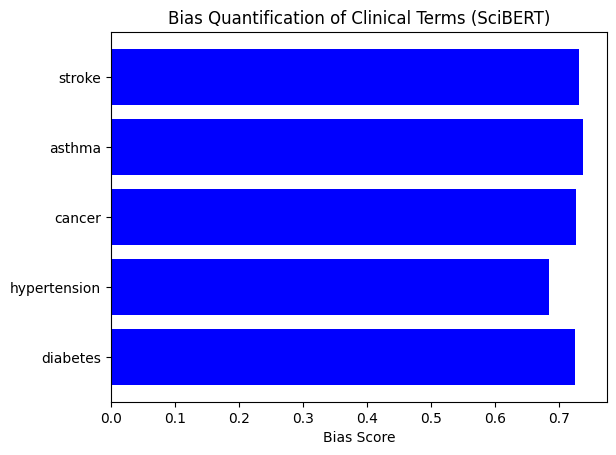

In [ ]:
import matplotlib.pyplot as plt

def plot_bias_scores(bias_scores):
    terms = list(bias_scores.keys())
    scores = list(bias_scores.values())
    plt.barh(terms, scores, color='blue')
    plt.xlabel('Bias Score')
    plt.title('Bias Quantification of Clinical Terms (SciBERT)')
    plt.show()

# Plot the bias scores for clinical terms
plot_bias_scores(bias_scores)
